```KPI```: Key Performance Indicators, are used to measure risk and return of a strategy，famous KPIs include:  
- Cumulative Annual Growth Rate (CAGR)  
- Annualized Volatility (Standard Deviation)  
- Sharp Ratio/ Sortino Ratio  
- Maximum Drawdown  
- Calmar Ratio

## I. CAGR:

公式:  
$$CAGR\ =\ (\frac{End\ Value}{Beginning\ Value})\LARGE^\frac{1}{year}\ -\ 1$$

重點:  
- CAGR 沒有考慮風險  
- CAGR 假設你會再投資 (以錢滾錢)  
- 通常 CAGR 會跟其他測量 volaility 的指標一起出現

#### 目標: 取 10 年的 ```S&P 500``` 的 "daily" 資料，並算出 CAGR

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf

In [5]:
ticker = "^GSPC" # the ticker of S&P 500
start = dt.datetime.today() - dt.timedelta(2500) # 取一年有 250 個交易日
end = dt.datetime.today()

In [6]:
dt.datetime() 

TypeError: function missing required argument 'year' (pos 1)

上面顯示錯誤的原因是: ```datetime``` 是一個 object，而我們要的是這個 object 裡的 ```.today()``` 方法。  
故 ```datetime``` 後面不須加 ```()```

In [9]:
SnP = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [10]:
def CAGR(DF):
    df = DF.copy()
    df['Daily Return'] = df['Adj Close'].pct_change() # first we need to calculate daily return
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod() # calculate cumulative return
    n = len(DF) / 250 # assume there are 250 trading days in a year
    cagr = (df['Cumulative Return'][-1])**(1/n) - 1 # we need the latest data to calculate CAGR
    return cagr

In [11]:
cagr = CAGR(SnP)

In [12]:
cagr

0.10777055470171648

## II. Annualized Volatility 

- Volatility of a strategy: the standard deviation of the returns  
- To annualized daily volatility: 對結果開 $\large\sqrt[2]{250}$ (假設一年有 250 個交易日)
- Assume the stock price is normally distributed (which is often not the case)  
- Does not capture tail risk

要開方的原因是，算出的 daily return 的 standard deviation，他的分母數字比較大 (因為週期是一天)，所以整體較小。  
所以如果要算 annualized 的 volatility，則必須將結果變大，因為 annualized standard deviation，分母是 1。  
Recall: 
$$Standard\ Deviation\ =\ $$

In [13]:
def Volatility(DF):
    df = DF.copy()
    df['Daily Return'] = df['Adj Close'].pct_change()
    vol = df['Daily Return'].std() * (250 ** 0.5) # converst daily volatility to annual volatility
    return vol

In [14]:
vol = Volatility(SnP)
vol

0.17866722546664107

The annualized volatility is about 18%

## Sharp ratio and Sortino ratio:

- 公式:  
$$\large Sharp\ Ratio\ =\ \frac{R_{p}-R_{f}}{\sigma_{p}}$$
$R_{p} = Expected\ Return$      
$R_{f} = Risk Free\ rate\ of\ return$

If Sharp ratio > 1: good, >2: very good, >3: excellent  
但有些人批評 Sharp ratio 考慮了正和負的 return，但應該只測量 return 是負的情況，因此 Sortino Ratio 就是另一個版本的 Sharp ratio，只是他只考慮負的 return 的情況

#### Sharp ratio python code

In [21]:
def Sharp(DF, rf): # rf stands for "risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf) / Volatility(df)
    return sr

In [22]:
sr = Sharp(SnP, 0.022) # assume a 2.2% risk free rate

In [23]:
sr

0.48005757338931027

#### Sortino Ratio python code

In [18]:
def Sortino(DF, rf):
    df = DF.copy()
    # extract only the negative daily return
    df['Daily Return'] = df['Adj Close'].pct_change()
    neg_re = df[df['Daily Return'] < 0]['Daily Return']
    neg_vol = (neg_re).std() * (250**0.5)
    sortino_r = (CAGR(df) - rf) / neg_vol
    return sortino_r

In [19]:
sortino_r = Sortino(SnP, 0.022) # assume the risk free rate = 2.2%

In [20]:
sortino_r

0.5465374933027076

用 Sortino Ratio 算出來的波動是 ```55%```，跟 Sharp Ratio 的 ```48%``` 相差 7 個百分點。  
這是合理的，因為 Sortino Rate 只考慮負的波動。

#### Data frame 條件取值

In [28]:
df = SnP.copy()
df['Daily Return'] = df['Adj Close'].pct_change()
df['Daily Return']

Date
2014-03-26         NaN
2014-03-27   -0.001900
2014-03-28    0.004640
2014-03-31    0.007924
2014-04-01    0.007039
                ...   
2021-01-21    0.000317
2021-01-22   -0.003011
2021-01-25    0.003616
2021-01-26   -0.001489
2021-01-27   -0.025678
Name: Daily Return, Length: 1723, dtype: float64

In [29]:
df['Daily Return'] < 0 # 用條件篩選，得出步林值

Date
2014-03-26    False
2014-03-27     True
2014-03-28    False
2014-03-31    False
2014-04-01    False
              ...  
2021-01-21    False
2021-01-22     True
2021-01-25    False
2021-01-26     True
2021-01-27     True
Name: Daily Return, Length: 1723, dtype: bool

In [30]:
df[ df['Daily Return'] < 0 ] # 取一個新的 data frame，"Daily Return" 就會是我們要的負數值

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2014-03-27,1852.109985,1855.550049,1842.109985,1849.040039,1849.040039,3733430000,-0.001900
2014-04-03,1891.430054,1893.800049,1882.650024,1888.770020,1888.770020,3055600000,-0.001126
2014-04-04,1890.250000,1897.280029,1863.260010,1865.089966,1865.089966,3583750000,-0.012537
2014-04-07,1863.920044,1864.040039,1841.479980,1845.040039,1845.040039,3801540000,-0.010750
2014-04-10,1872.280029,1872.530029,1830.869995,1833.079956,1833.079956,3758780000,-0.020885
...,...,...,...,...,...,...,...
2021-01-14,3814.979980,3823.600098,3792.860107,3795.540039,3795.540039,5180140000,-0.003753
2021-01-15,3788.729980,3788.729980,3749.620117,3768.250000,3768.250000,5353060000,-0.007190
2021-01-22,3844.239990,3852.310059,3830.409912,3841.469971,3841.469971,5080430000,-0.003011


## III. Maximum Drawdown and Calmar Ratio

Maximum Drawdown:  
- Largest percentage drop in asset price over a specific time period  
- 在比較不同股票的此數值時，要注意 time horizon 必須要一樣，因為週期較大的股票，有更大的機率會有較大的 Maximum Drawdown  

Calmar Ratio:   
- The ratio of CAGR and Maximum Drawdown  
- A measure of risk adjusted return

In [48]:
def Max_DD(DF):
    df = DF.copy()
    df['Daily Return'] = df['Adj Close'].pct_change()
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod() # 這麼多天的總報酬
    df['Cumulative Rolling Max'] = df['Cumulative Return'].cummax() # ?

    df['Draw Down'] = df['Cumulative Rolling Max'] - df['Cumulative Return']
    df['Draw Down Percentage'] = df['Draw Down'] / df['Cumulative Rolling Max']

    max_dd = df['Draw Down Percentage'].max()
    return max_dd

In [49]:
max_dd = Max_DD(SnP)
max_dd

0.3392496000265329

檢查得出的值是否合理:

<AxesSubplot:xlabel='Date'>

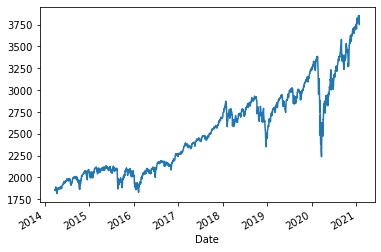

In [51]:
df = SnP.copy()

df['Adj Close'].plot()

上圖中最大的 Draw Down 大概在 2020 年初，當時由約 3250，下跌到 2250，因此 Maxmium Draw Down 便是 (3250-2250)/3250 = 0.307 (跟用函數算出來的差不多)  
    
下方為錯誤的檢查方式，因為 Draw Down 是測量下跌的幅度，直接用最大減最小，可能會有時間順序的不同。

In [55]:
dfMax = df['Adj Close'].max()
dfMin = df['Adj Close'].min()

print((dfMax-dfMin)/dfMin)

1.1233581899098382


#### Calmar Ratio python code

In [56]:
def Calmar(DF):
    df = DF.copy()
    clmr = CAGR(df) / Max_DD(df)
    return clmr

In [60]:
clmr = Calmar(SnP)
print(CAGR(SnP)/Max_DD(SnP))

0.3176733434417835


In [58]:
clmr

0.3176733434417835